In [1]:
import io
import requests
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, Dinov2Model

device = "cuda" if torch.cuda.is_available() else "cpu"

img = Image.open("//home/mak/PycharmProjects/SegEdge/notebooks/Upscaler/Namibia.png").convert("RGB")


In [2]:
from transformers import AutoModel

# 2) DINOv3 ViT-L/16 features (tokens at 32x32 for 500 with patch 16)
processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vitl16-pretrain-lvd1689m")
model = AutoModel.from_pretrained("facebook/dinov3-vitl16-pretrain-lvd1689m", token=False).to(device).eval()



In [3]:

img_size = 600

inputs = processor(
    images=img,
    do_resize=True,
    size={"shortest_edge": img_size},
    do_center_crop=True,
    crop_size={"height": img_size, "width": img_size},
    return_tensors="pt",
)
hr_image = inputs["pixel_values"].to(device)  #

with torch.no_grad():
    out = model(pixel_values=hr_image)
    tokens = out.last_hidden_state[:, 1:, :]  # drop [CLS]

B, N, C = tokens.shape
h = w = int(N ** 0.5)
if not  h * w == N:


    print (f"Non-square token grid (N={N})")
    print("Original tokens shape:", tokens.shape)

    #cut to square
    new_N = h * h
    tokens = tokens[:, :new_N, :]
    print("Cut tokens to:", tokens.shape)


lr_features = tokens.reshape(B, h, w, C).permute(0, 3, 1, 2).contiguous()  # (1, C, 32, 32)


Non-square token grid (N=1373)
Original tokens shape: torch.Size([1, 1373, 1024])
Cut tokens to: torch.Size([1, 1369, 1024])


In [4]:
# 3) Load AnyUp from torch.hub and upsample to 448x448
#    (hr_image must be ImageNet-normalized; lr_features can be from any encoder)
upsampler = torch.hub.load("wimmerth/anyup", "anyup", verbose=False).to(device).eval()
with torch.no_grad():
    # q_chunk_size can reduce memory if needed
    hr_features = upsampler(hr_image, lr_features, q_chunk_size=256)

In [5]:
print(hr_features.shape)

B, C, H, W = hr_features.shape
X = hr_features.permute(0, 2, 3, 1).reshape(B, -1, C)   # (90000, 1024)

print("X shape: ",X.shape)

torch.Size([1, 1024, 600, 600])
X shape:  torch.Size([1, 360000, 1024])


In [6]:
# we’ll cluster in feature space, so build a 2D matrix X = (num_patches × feature_dim)
import numpy as np

# L2-normalize each patch vector so distance ~ cosine distance (helps k-means separate textures like roads/roofs)
X = X[0].detach().cpu().numpy().astype("float32")
X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)

# print sanity checks before clustering
print("X shape:", X.shape, " mean L2 norm:", float(np.linalg.norm(X, axis=1).mean()))


X shape: (360000, 1024)  mean L2 norm: 1.0


In [7]:
from sklearn.cluster import KMeans
# we’ll use MiniBatchKMeans to group similar patch embeddings (fast, memory-friendly) into k semantic clusters
from sklearn.cluster import MiniBatchKMeans

# choose an initial cluster count (k=8 is a reasonable start to separate roads/roofs/veg/shadows etc.)
kmeans = MiniBatchKMeans(n_clusters=50, random_state=12, batch_size=2048, max_iter=100)

# run clustering on the L2-normalized embeddings to obtain one label per patch (0..k-1)
labels = kmeans.fit_predict(X)

# report how many patches fell into each cluster so we can gauge balance before mapping to the image grid
print("labels shape:", labels.shape, " | counts per cluster:", np.bincount(labels, minlength=8))


labels shape: (360000,)  | counts per cluster: [ 4828 10065 11919  9612 10567  7132 10276  6329  6612 11322  9875  9851
 11006 11350  7369 14570 10065  7328  4908 11718  9803  8158  5170 10751
  8152  6431  9843  7069  8403 12197  9718  5092 10271  9803  8841  9595
 11784  4480  8498  9239]


In [8]:

# derive patches per side and confirm P = Hp*Wp matches 90000
ps = 16
Hp, Wp = H // ps, W // ps

label_grid = labels.reshape(H, W)

# quick sanity: report grid shape and how many distinct clusters are present
print("label_grid:", label_grid.shape, " unique clusters:", np.unique(label_grid).size)



label_grid: (600, 600)  unique clusters: 40


visualizing clusters @ 600x600 with 40 clusters


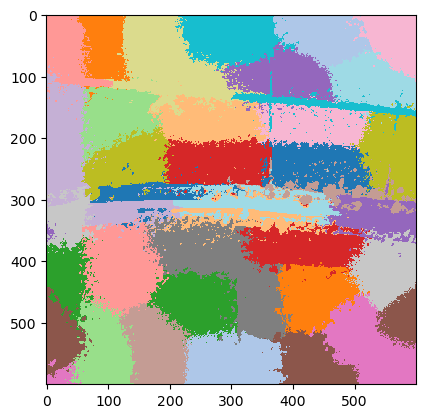

In [9]:
# import plotting; we'll use a discrete palette so clusters are clearly distinct
import matplotlib.pyplot as plt
# render the label grid with a categorical colormap and no smoothing between patches
plt.imshow(label_grid, cmap="tab20", interpolation="nearest")
# print a quick status so you know what you’re seeing (grid size and number of clusters)
print(f"visualizing clusters @ {label_grid.shape[0]}x{label_grid.shape[1]} with {label_grid.max()+1} clusters")
# display the figure
plt.show()


Low Res Clusters

In [10]:
print(lr_features.shape)

B, C, H, W = lr_features.shape
X = lr_features.permute(0, 2, 3, 1).reshape(B, -1, C)   # (90000, 1024)

print("X shape: ",X.shape)

torch.Size([1, 1024, 37, 37])
X shape:  torch.Size([1, 1369, 1024])


In [11]:
# we’ll cluster in feature space, so build a 2D matrix X = (num_patches × feature_dim)
import numpy as np

# L2-normalize each patch vector so distance ~ cosine distance (helps k-means separate textures like roads/roofs)
X = X[0].detach().cpu().numpy().astype("float32")
X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)

# print sanity checks before clustering
print("X shape:", X.shape, " mean L2 norm:", float(np.linalg.norm(X, axis=1).mean()))


X shape: (1369, 1024)  mean L2 norm: 1.0


In [12]:
from sklearn.cluster import KMeans
# we’ll use MiniBatchKMeans to group similar patch embeddings (fast, memory-friendly) into k semantic clusters
from sklearn.cluster import MiniBatchKMeans

# choose an initial cluster count (k=8 is a reasonable start to separate roads/roofs/veg/shadows etc.)
kmeans =KMeans(n_clusters=20, n_init="auto", random_state=0)

# run clustering on the L2-normalized embeddings to obtain one label per patch (0..k-1)
labels = kmeans.fit_predict(X)

# report how many patches fell into each cluster so we can gauge balance before mapping to the image grid
print("labels shape:", labels.shape, " | counts per cluster:", np.bincount(labels, minlength=8))


labels shape: (1369,)  | counts per cluster: [ 30 102  64 128  92 100  95 107  27  56  71  22  69  54  84  62  60  45
  33  68]


In [13]:

# derive patches per side and confirm P = Hp*Wp matches 90000
ps = 16
Hp, Wp = H // ps, W // ps

label_grid = labels.reshape(H, W)

# quick sanity: report grid shape and how many distinct clusters are present
print("label_grid:", label_grid.shape, " unique clusters:", np.unique(label_grid).size)



label_grid: (37, 37)  unique clusters: 20


visualizing clusters @ 37x37 with 20 clusters


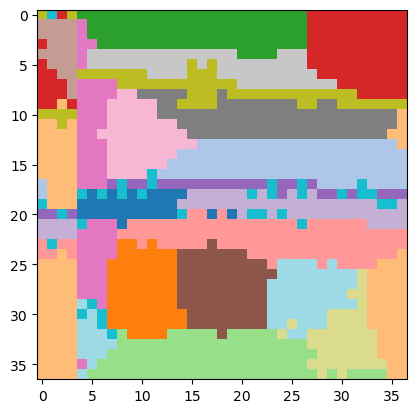

In [14]:
# import plotting; we'll use a discrete palette so clusters are clearly distinct
import matplotlib.pyplot as plt
# render the label grid with a categorical colormap and no smoothing between patches
plt.imshow(label_grid, cmap="tab20", interpolation="nearest")
# print a quick status so you know what you’re seeing (grid size and number of clusters)
print(f"visualizing clusters @ {label_grid.shape[0]}x{label_grid.shape[1]} with {label_grid.max()+1} clusters")
# display the figure
plt.show()
